In [1]:
# Use with NHL_Model_Data_Transform_v5.py
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Transformed.csv")
#df = pd.read_csv(r"C:\Users\zanec\OneDrive\Documents\Python\NHL_data\NHL_Data_Transformed_PCA - Test v1.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4261 entries, 0 to 4260
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   team_Home                  4261 non-null   object 
 1   gameId                     4261 non-null   int64  
 2   home_or_away_Home          4261 non-null   object 
 3   win_or_lose_Home           4261 non-null   int64  
 4   seasonPointsPerGame_Home   4261 non-null   float64
 5   goalDiffAvg_Home           4261 non-null   float64
 6   hitsDiffAvg_Home           4261 non-null   float64
 7   pointsFromGameAvg_Home     4261 non-null   float64
 8   fenwickPercentageAvg_Home  4261 non-null   float64
 9   reboundsForAvg_Home        4261 non-null   float64
 10  team_Away                  4261 non-null   object 
 11  home_or_away_Away          4261 non-null   object 
 12  win_or_lose_Away           4261 non-null   int64  
 13  seasonPointsPerGame_Away   4261 non-null   float

In [4]:
df = df.drop(columns=['team_Home','team_Away','gameId','home_or_away_Home','home_or_away_Away','win_or_lose_Away'])

In [5]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

In [6]:
# Heatmap to visualize correlations
corr_matrix = df.corr(numeric_only=True)
# sns.heatmap(corr_matrix, cmap="PiYG")

In [7]:
corr_matrix['win_or_lose_Home'].sort_values(ascending=False)

win_or_lose_Home             1.000000
seasonPointsPerGame_Home     0.308311
fenwickPercentageAvg_Home    0.139362
goalDiffAvg_Home             0.076082
pointsFromGameAvg_Home       0.072489
hitsDiffAvg_Away             0.057848
reboundsForAvg_Home          0.041695
penaltiesAgainstTotal        0.021285
penaltiesForTotal           -0.016758
hitsDiffAvg_Home            -0.022717
reboundsForAvg_Away         -0.048594
goalDiffAvg_Away            -0.085647
pointsFromGameAvg_Away      -0.091419
fenwickPercentageAvg_Away   -0.143173
seasonPointsPerGame_Away    -0.302446
Name: win_or_lose_Home, dtype: float64

In [8]:
# Visualize distributions of attributes
# from pandas.plotting import scatter_matrix

# attributes = ['fenwickPercentageAvg_Home','goalDiffAvg_Home','seasonPointsPerGame_Home','seasonPointsPerGame_Away']
# scatter_matrix(df[attributes], figsize=(12,8));

In [9]:
# These are tentative just to test

df_Final = df
# df_Final = df.drop(columns=['corsiPercentageAvg_Away','penaltiesAgainstTotal','shotsOnGoalDiffAvg_Away'])

In [10]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data
train_set, test_set = train_test_split(df_Final, test_size=0.2, random_state=42)

nhl = train_set.drop('win_or_lose_Home', axis=1)
nhl_labels = train_set['win_or_lose_Home'].copy()

df_Final = df_Final.drop('win_or_lose_Home', axis=1)

In [11]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

nhl_prepared = num_pipeline.fit_transform(nhl)

In [12]:
# Fine Tune the hyperparameters of RandomForest model
# from sklearn.model_selection import GridSearchCV

# param_grid = [{'n_estimators' : [100,500,1000], 'max_leaf_nodes': [10,16,25,50], 'n_jobs' : [-1]},
#               {'bootstrap': [False], 'n_estimators' : [100,500,1000], 'max_leaf_nodes': [10,16,25,50], 'n_jobs' : [-1]},]

# rnd_clf_test = RandomForestClassifier()

# grid_search = GridSearchCV(rnd_clf_test, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# grid_search.fit(nhl_prepared,nhl_labels)

# grid_search.best_params_

In [13]:
# cvres = grid_search.cv_results_
# results = []
# for mean_scores, params in zip(cvres["mean_test_score"], cvres["params"]):
#     results.append([np.sqrt(-mean_scores),params])

# results2 = sorted(results, key=lambda x: x[0])
# print(*results2, sep = '\n')

In [14]:
# Search for number of dimensions needed to preserve 95% of variance

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(nhl_prepared)
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_feature_PCA = np.argmax(cumsum >= 0.95) + 1

pca = PCA(n_components = num_feature_PCA)
pca.fit_transform(nhl_prepared)
pca.explained_variance_ratio_

array([0.19922762, 0.16253961, 0.11949165, 0.09528954, 0.08960649,
       0.06760627, 0.0578003 , 0.04971681, 0.04817124, 0.03770121,
       0.03369897])

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

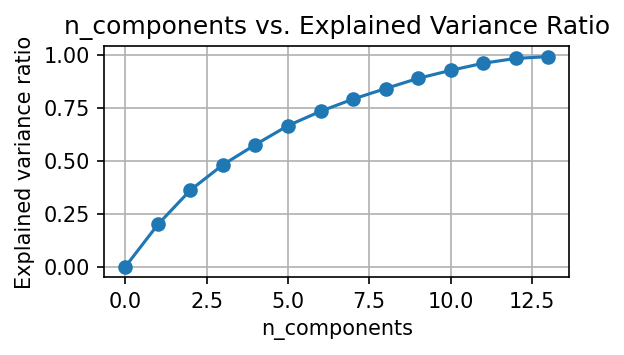

In [15]:
# Visualize variance sum with component #s
import numpy as np
nums = np.arange(df_Final.shape[1])

var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(nhl_prepared)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

import matplotlib.pyplot as plt

plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [16]:
features_PCA = []
for i in range (1, num_feature_PCA+1):
    features_PCA.append(f'PCA_{i}')

pca = PCA(n_components = num_feature_PCA)
nhl_prepared_PCA = pca.fit_transform(nhl_prepared)
#print(pd.DataFrame(pca.components_,columns=df_Final.columns[0:nhl_prepared.shape[1]+1],index = [features_PCA]))

In [24]:
# Try using a Decision Tree with Bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, 
                            random_state=69)
bag_clf.fit(nhl_prepared_PCA,nhl_labels)


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=69)

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(bag_clf, nhl_prepared_PCA, nhl_labels, cv=5)

from sklearn.metrics import confusion_matrix

confusion_matrix(nhl_labels, y_train_pred)

array([[1000,  601],
       [ 508, 1299]], dtype=int64)

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('When claiming is a win, correct % is ', precision_score(nhl_labels, y_train_pred))

print('Detected % of wins' ,recall_score(nhl_labels, y_train_pred))

print('F1 score is ', f1_score(nhl_labels, y_train_pred))

print('Accuracy score is ', accuracy_score(nhl_labels, y_train_pred))

When claiming is a win, correct % is  0.6836842105263158
Detected % of wins 0.7188710570005534
F1 score is  0.7008362557323983
Accuracy score is  0.6745892018779343


In [ ]:
df_Predict = pd.read_csv(r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\NHL_data\NHL_Data_Predict.csv")
#df_Predict = pd.read_csv(r"C:\Users\zanec\OneDrive\Documents\Python\NHL_data\NHL_Data_Predict.csv")

In [ ]:
nhl_Predict = df_Predict.iloc[:,2:]

nhl_Predict_PCA = pca.transform(nhl_Predict)


np.array((df_Predict.iloc[:,1].values,bag_clf.predict(nhl_Predict_PCA))).T